## Описание работы

Есть упрощённая модель данных сервиса по доставке продуктов.

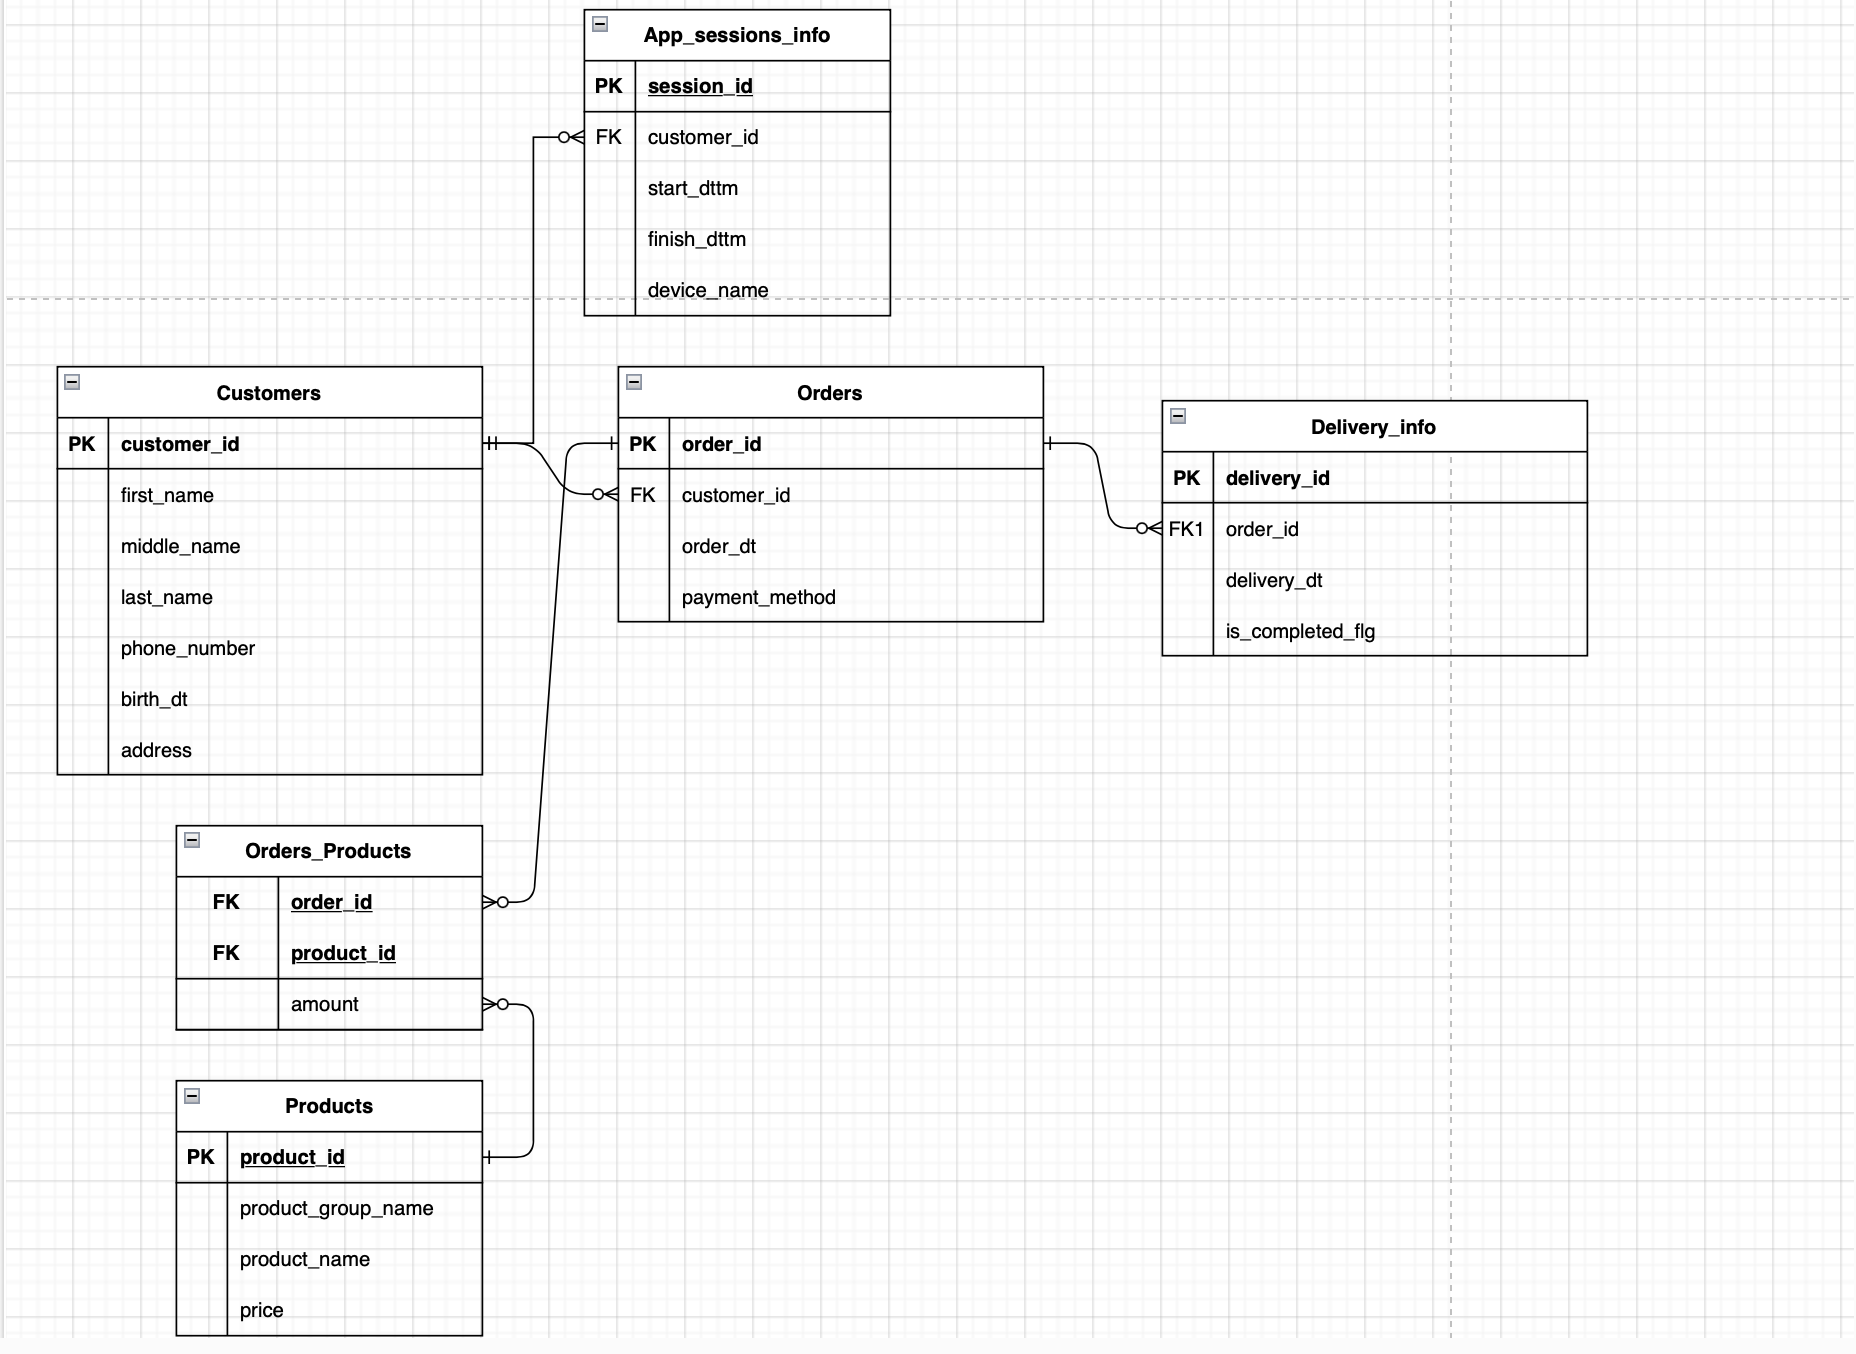

Цель работы - объединить данные, построить модели прогнозирования времени доставки по заказам и выполнить оценку их качества

Задачи:
1) Получить необходимые данные для прогнозирования, определить целевую переменную, построить и сравнить модели прогнозирования с помощью кросс-валидации;

2) Сделать выводы по полученным результатам и определить, какой алгоритм оказался лучшим на кросс-валидации. 

## 1. Импорт сторонних библиотек

In [1]:
import pandas as pd
import datetime
import missingno as msno
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import scipy.stats as st

from matplotlib import ticker
from matplotlib.ticker import FormatStrFormatter
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler, OrdinalEncoder
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, r2_score, classification_report

## 2. Загрузка данных

1. Загрузка данных из файлов.

In [2]:
app_sess = pd.read_csv('Данные/app_sess.csv')
customers = pd.read_csv('Данные/customers.csv')
info = pd.read_csv('Данные/info.csv')
orders = pd.read_csv('Данные/orders.csv')
orders_product = pd.read_csv('Данные/orders_product.csv')
products = pd.read_csv('Данные/products.csv')

2. Вывод размерности и первых 5 строчек данных.

In [3]:
print(f'Размерность датасета app_sess: {app_sess.shape}')
app_sess.head()

Размерность датасета app_sess: (5336, 5)


,session_id,customer_id,start_dttm,finish_dttm,device_name
0,1,4374148,08.01.20 3:37,09.01.20 6:29,iOS
1,2,1587527,19.02.23 16:45,20.02.23 18:16,Windows
2,3,7864358,25.01.20 10:36,26.01.20 22:32,iOS
3,4,6520695,28.04.23 9:17,29.04.23 18:40,iOS
4,5,9700458,16.03.23 8:11,16.03.23 13:40,Ubuntu


In [4]:
print(f'Размерность датасета customers: {customers.shape}')
customers.head()

Размерность датасета customers: (501, 7)


,customer_id,last_name,first_name,middle_name,phone_number,birth_dt,address
0,10760.0,Пантелеев,Макар,Александрович,897935.0,16.10.1997,Люберцы
1,45933.0,Толкачева,Амелия,Тимофеевна,852832.0,11.10.1948,Грозный
2,46175.0,Сергеева,Ксения,Захаровна,861185.0,29.05.1946,Новошахтинск
3,91618.0,Михайлова,Кристина,Андреевна,852956.0,18.04.1940,Нальчик
4,105077.0,Сидоров,Евгений,Дмитриевич,846586.0,17.03.1961,Абакан


In [5]:
print(f'Размерность датасета info: {info.shape}')
info.head()

Размерность датасета info: (3039, 4)


,delivery_id,order_id,delivery_dt,is_completed_flg
0,1,98929,23-05-2023,False
1,2,51229,03-05-2023,True
2,3,12295,16-04-2022,False
3,4,24511,03-06-2023,True
4,5,22832,03-04-2022,True


In [6]:
print(f'Размерность датасета orders: {orders.shape}')
orders.head()

Размерность датасета orders: (2950, 4)


,order_id,customer_id,order_dt,payment_method
0,99983,4951223,07.12.2021,offline
1,99969,1806908,29.07.2022,offline
2,99868,2576384,27.09.2021,online
3,99757,816871,02.04.2021,offline
4,99710,7864358,26.01.2020,online


In [7]:
print(f'Размерность датасета orders_product: {orders_product.shape}')
orders_product.head()

Размерность датасета orders_product: (5990, 3)


,order_id,product_id,amount
0,52414,4,33
1,73440,3,50
2,39895,9,5
3,78025,14,8
4,36414,8,39


In [8]:
print(f'Размерность датасета products: {products.shape}')
products.head()

Размерность датасета products: (15, 4)


,product_id,product_group_name,product_name,Price
0,1,Одежда,Носки,500
1,2,Одежда,Штаны,2100
2,3,Одежда,Юбка,10000
3,4,Одежда,Рубашка,15000
4,5,Часы,Часы наручные,1000


3. Выполним объединение датасетов по общим атрибутам и выведем итоговую размерность получившегося датасета, а также первые пять строчек.

In [9]:
df = pd.merge(left = orders, right = info, on = 'order_id', how = 'inner')
df = df.merge(customers , on = 'customer_id', how = 'inner')
df = df.merge(app_sess , on = 'customer_id', how = 'inner')
df1 = pd.merge(left = orders_product, right = products, on = 'product_id', how = 'inner')
df_new = df.merge(df1 , on = 'order_id', how = 'inner')

In [10]:
print(f'Размерность объединённого датасета: {df_new.shape}')
df_new.head()

Размерность объединённого датасета: (67467, 22)


,order_id,customer_id,order_dt,payment_method,delivery_id,delivery_dt,is_completed_flg,last_name,first_name,middle_name,...,address,session_id,start_dttm,finish_dttm,device_name,product_id,amount,product_group_name,product_name,Price
0,99983,4951223,07.12.2021,offline,81,17-01-2022,True,Андреев,Михаил,Глебович,...,Уссурийск,380,06.12.21 7:06,07.12.21 8:38,MacOS,3,24,Одежда,Юбка,10000
1,99983,4951223,07.12.2021,offline,81,17-01-2022,True,Андреев,Михаил,Глебович,...,Уссурийск,380,06.12.21 7:06,07.12.21 8:38,MacOS,13,14,Напитки,Злой кола,500
2,99983,4951223,07.12.2021,offline,81,17-01-2022,True,Андреев,Михаил,Глебович,...,Уссурийск,716,06.12.21 15:38,08.12.21 2:40,MacOS,3,24,Одежда,Юбка,10000
3,99983,4951223,07.12.2021,offline,81,17-01-2022,True,Андреев,Михаил,Глебович,...,Уссурийск,716,06.12.21 15:38,08.12.21 2:40,MacOS,13,14,Напитки,Злой кола,500
4,99983,4951223,07.12.2021,offline,81,17-01-2022,True,Андреев,Михаил,Глебович,...,Уссурийск,1546,06.12.21 20:51,08.12.21 0:18,iOS,3,24,Одежда,Юбка,10000


## 3. Data Preparation

### 3.1 Исследование данных на дубликаты и пропуски

1. Вывод матрицы пропусков для `df_new`

Матрица пропусков


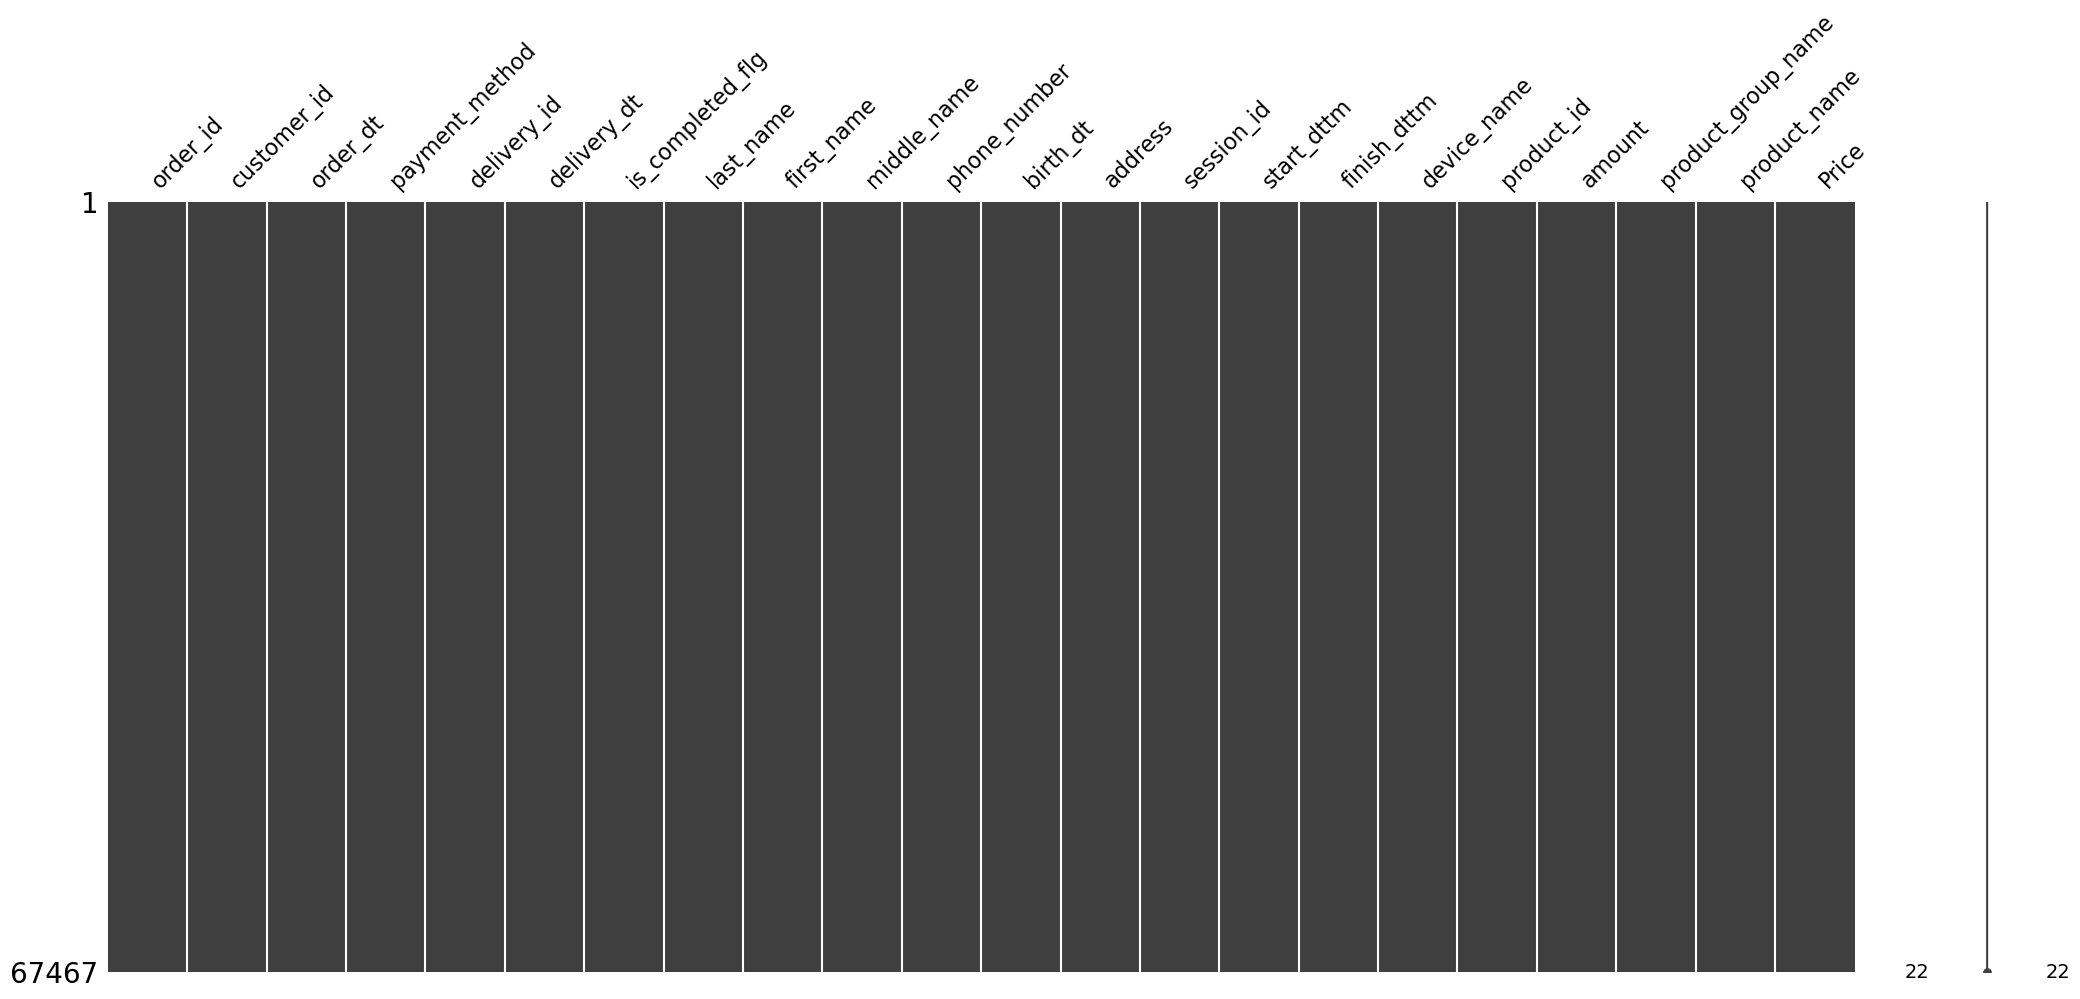

In [11]:
print('Матрица пропусков')
msno.matrix(df_new);

2. Вывод количества полностью заполненных объектов и показатель плотности данных.

In [12]:
print(f'Количество полностью заполненных объектов для датасета: {len(df_new.dropna())}')
print(f'Плотность данных: {round((len(df_new.dropna()) / len(df_new)) * 100 , 2)} %')

Количество полностью заполненных объектов для датасета: 67467
Плотность данных: 100.0 %


Пропусков в данных не обнаружено.

3. Выявление дубликатов `df_new`. Подсчёт значения уникальности данных

In [13]:
print(f'Уникальность данных составляет: {round(df_new.drop_duplicates().shape[0] / df_new.shape[0], 5)}')

Уникальность данных составляет: 1.0


Дубликатов в данных не обнаружено.

### 3.2 Преобразование типов данных

1. Вывод общей информации о датасете для анализа типа данных

In [14]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 67467 entries, 0 to 67466
Data columns (total 22 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   order_id            67467 non-null  int64  
 1   customer_id         67467 non-null  int64  
 2   order_dt            67467 non-null  object 
 3   payment_method      67467 non-null  object 
 4   delivery_id         67467 non-null  int64  
 5   delivery_dt         67467 non-null  object 
 6   is_completed_flg    67467 non-null  bool   
 7   last_name           67467 non-null  object 
 8   first_name          67467 non-null  object 
 9   middle_name         67467 non-null  object 
 10  phone_number        67467 non-null  float64
 11  birth_dt            67467 non-null  object 
 12  address             67467 non-null  object 
 13  session_id          67467 non-null  int64  
 14  start_dttm          67467 non-null  object 
 15  finish_dttm         67467 non-null  object 
 16  devi

2. Изменение типа данных для `phone_number` на целочисленный тип

In [15]:
df_new.phone_number = df_new.phone_number.astype(int)
print(f' Тип данных для phone_number: {df_new.phone_number.dtype}')

 Тип данных для phone_number: int32


3. Изменение типа данных для дат на Datetime-формат

In [16]:
df_new['order_dt'] = pd.to_datetime(df_new['order_dt'], format = "%d.%m.%Y", infer_datetime_format=True, utc=True)
df_new['delivery_dt'] = pd.to_datetime(df_new['delivery_dt'], format = "%d-%m-%Y", infer_datetime_format=True, utc=True)
df_new['birth_dt'] = pd.to_datetime(df_new['birth_dt'], format = "%d.%m.%Y", infer_datetime_format=True, utc=True)
df_new['start_dttm'] = pd.to_datetime(df_new['start_dttm'], format = "%d.%m.%y %H:%M", infer_datetime_format=True, utc=True)
df_new['finish_dttm'] = pd.to_datetime(df_new['finish_dttm'], format = "%d.%m.%y %H:%M", infer_datetime_format=True, utc=True)

In [17]:
print(f' Тип данных для order_dt: {df_new.order_dt.dtype}')
print(f' Тип данных для delivery_dt: {df_new.delivery_dt.dtype}')
print(f' Тип данных для birth_dt: {df_new.birth_dt.dtype}')
print(f' Тип данных для start_dttm: {df_new.start_dttm.dtype}')
print(f' Тип данных для finish_dttm: {df_new.finish_dttm.dtype}')

 Тип данных для order_dt: datetime64[ns, UTC]
 Тип данных для delivery_dt: datetime64[ns, UTC]
 Тип данных для birth_dt: datetime64[ns, UTC]
 Тип данных для start_dttm: datetime64[ns, UTC]
 Тип данных для finish_dttm: datetime64[ns, UTC]


4. Изменение типа данных для `is_completed_flg` на строчный формат

In [18]:
df_new.is_completed_flg = df_new.is_completed_flg.astype(str)
print(f' Тип данных для is_completed_flg: {df_new.is_completed_flg.dtype}')

 Тип данных для is_completed_flg: object


### 3.3 Исследование данных на выбросы и аномалиии

#### 3.3.1 Выявление аномалий в качественных переменных

1. Для качественных переменных выведем уникальные значения и количесто их повторений

In [19]:
df_new.payment_method.value_counts()

offline    35758
online     31709
Name: payment_method, dtype: int64

In [20]:
df_new.is_completed_flg.value_counts()

True     34006
False    33461
Name: is_completed_flg, dtype: int64

In [21]:
df_new.last_name.value_counts()

Иванова       1361
Крылов        1111
Яковлев       1068
Васильев       963
Михайлова      818
              ... 
Тихомирова      16
Панков          12
Алексеева       11
Пирогова         9
Филимонов        8
Name: last_name, Length: 328, dtype: int64

In [22]:
df_new.first_name.value_counts()

Максим     2376
Анна       2186
Алексей    2130
Мария      1855
Михаил     1800
           ... 
Тимур        40
Диана        30
Лидия        24
Татьяна      21
Арсен        16
Name: first_name, Length: 128, dtype: int64

In [23]:
df_new.middle_name.value_counts()

Александрович    3027
Александровна    2409
Андреевич        2083
Ивановна         1947
Данииловна       1859
                 ... 
Сергеевна          33
Демидовна          33
Леонидовна         30
Захарович          24
Тимурович          22
Name: middle_name, Length: 140, dtype: int64

In [24]:
df_new.address.value_counts()

Сарапул         855
Биробиджан      811
Щекино          749
Архангельск     726
Апатиты         719
               ... 
Орел             16
Калуга           16
Норильск         12
Лиски            12
Петрозаводск      8
Name: address, Length: 316, dtype: int64

In [25]:
df_new.device_name.value_counts()

iOS        14234
Android    13648
MacOS      13476
Ubuntu     13398
Windows    12711
Name: device_name, dtype: int64

In [26]:
df_new.product_group_name.value_counts()

Часы        18182
Одежда      17544
Продукты    17308
Напитки     14433
Name: product_group_name, dtype: int64

In [27]:
df_new.product_name.value_counts()

Злой кола          5124
Часы настенные     4970
Вода               4950
Рубашка            4754
Часы с кукушкой    4717
Круассан           4696
Юбка               4523
Молоко             4476
Хлеб               4360
Сок                4359
Часы напольные     4316
Носки              4235
Часы наручные      4179
Штаны              4032
Огурец             3776
Name: product_name, dtype: int64

Аномалий в качественных переменных не выявлено.

#### 3.3.2 Выявление аномалий в количественных переменных

1. Вывод описательной статистики для данных

In [28]:
round(df_new.describe() , 2)

,order_id,customer_id,delivery_id,phone_number,session_id,product_id,amount,Price
count,67467.00,67467.00,67467.00,67467.00,67467.00,67467.00,67467.00,67467.00
mean,50277.30,5082888.93,1540.74,849298.75,2682.94,8.11,25.60,8545.86
std,28418.67,2880391.16,876.91,28434.45,1534.96,4.32,14.67,22735.25
min,87.00,45933.00,2.00,800022.00,1.00,1.00,1.00,5.00
25%,25907.00,2576384.00,776.00,825690.00,1380.00,4.00,13.00,50.00
50%,50482.00,4773017.00,1545.00,847710.00,2691.00,8.00,26.00,500.00
75%,73609.00,7664568.00,2306.00,876440.00,3989.00,12.00,38.00,3000.00
max,99983.00,9983236.00,3039.00,899993.00,5336.00,15.00,50.00,90000.00


2. Ввиду того, что атрибуты `order_id`, `customer_id`, `delivery_id`, `phone_number`, `session_id` и `product_id`  являются качественными переменными, исследование на выбросы и аномалии не производим. Выведем гистограммы распределения по атрибутам `amount` и `Price`, а также графики размаха для выявления выбросов

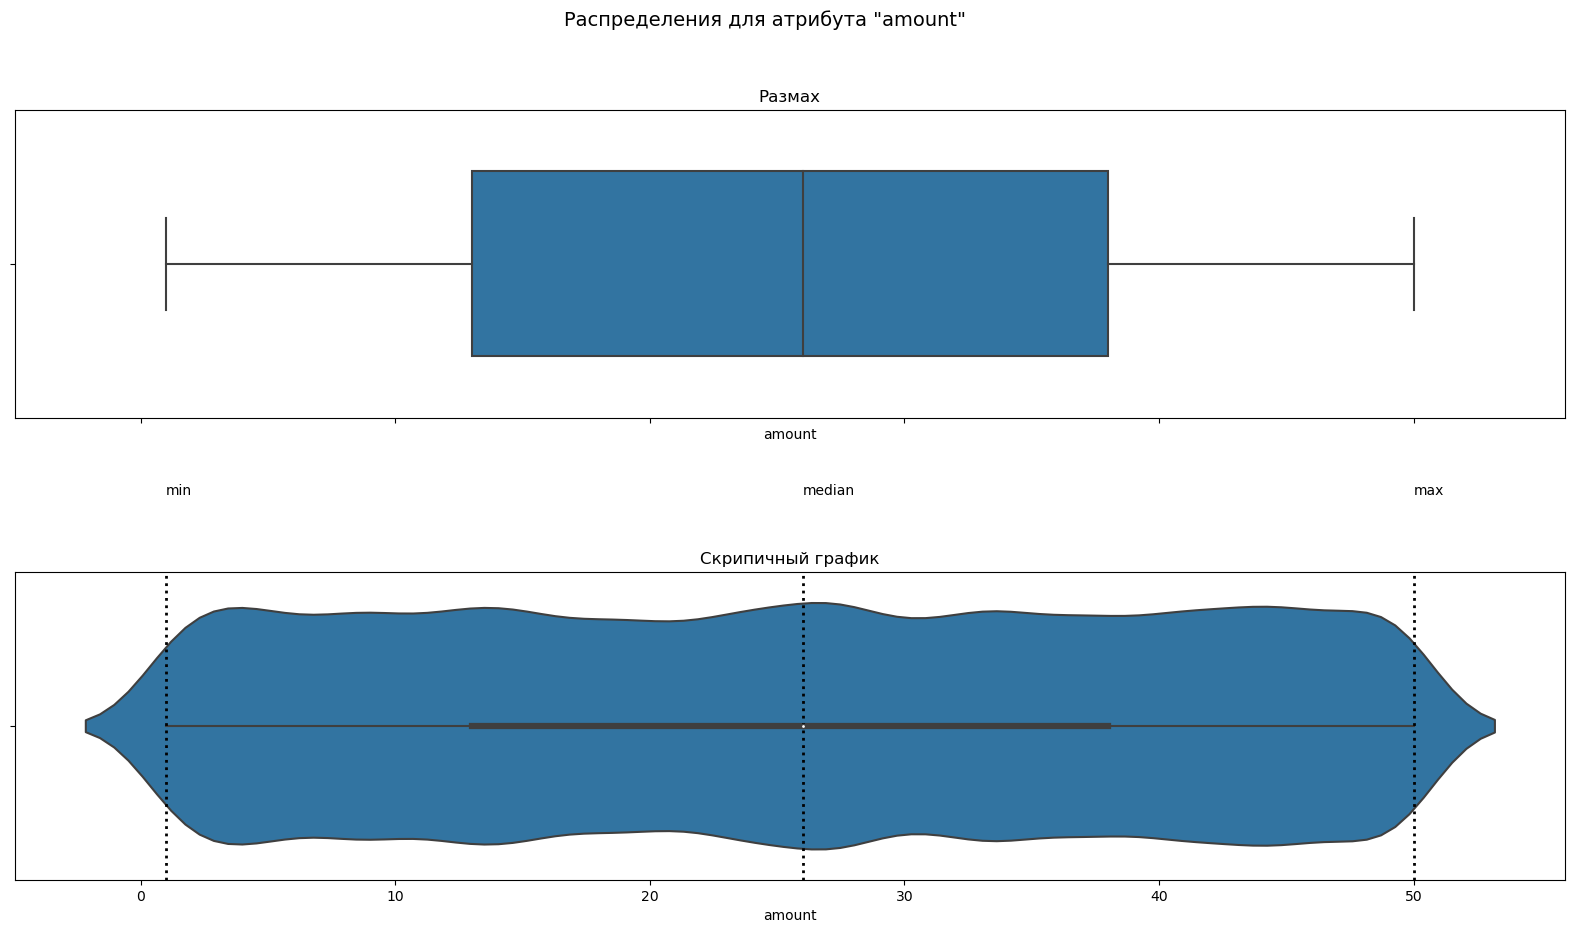

In [29]:
fig, ax = plt.subplots(2, 1, figsize = (20, 10), sharex = True)
fig.suptitle('Распределения для атрибута "amount"', fontsize = 14)
fig.subplots_adjust(hspace = 0.5)
    
sns.boxplot(data = df_new, x = 'amount', width=0.6, ax = ax[0])
ax[0].text(df_new['amount'].median(), 0.75,  'median')
ax[0].text(df_new['amount'].min(), 0.75,  'min')
ax[0].text(df_new['amount'].max(), 0.75,  'max')
ax[0].set_title('Размах', fontsize = 12)

sns.violinplot(data = df_new, x = 'amount', fill=False, ax = ax[1])
ax[1].axvline(df_new['amount'].median(), color = 'black', linestyle = 'dotted', linewidth = 2)
ax[1].axvline(df_new['amount'].min(), color = 'black', linestyle = 'dotted', linewidth = 2)
ax[1].axvline(df_new['amount'].max(), color = 'black', linestyle = 'dotted', linewidth = 2)
ax[1].set_title('Скрипичный график', fontsize = 12)
plt.show()

Выбросов по атрибуту `amount` не обнаружено

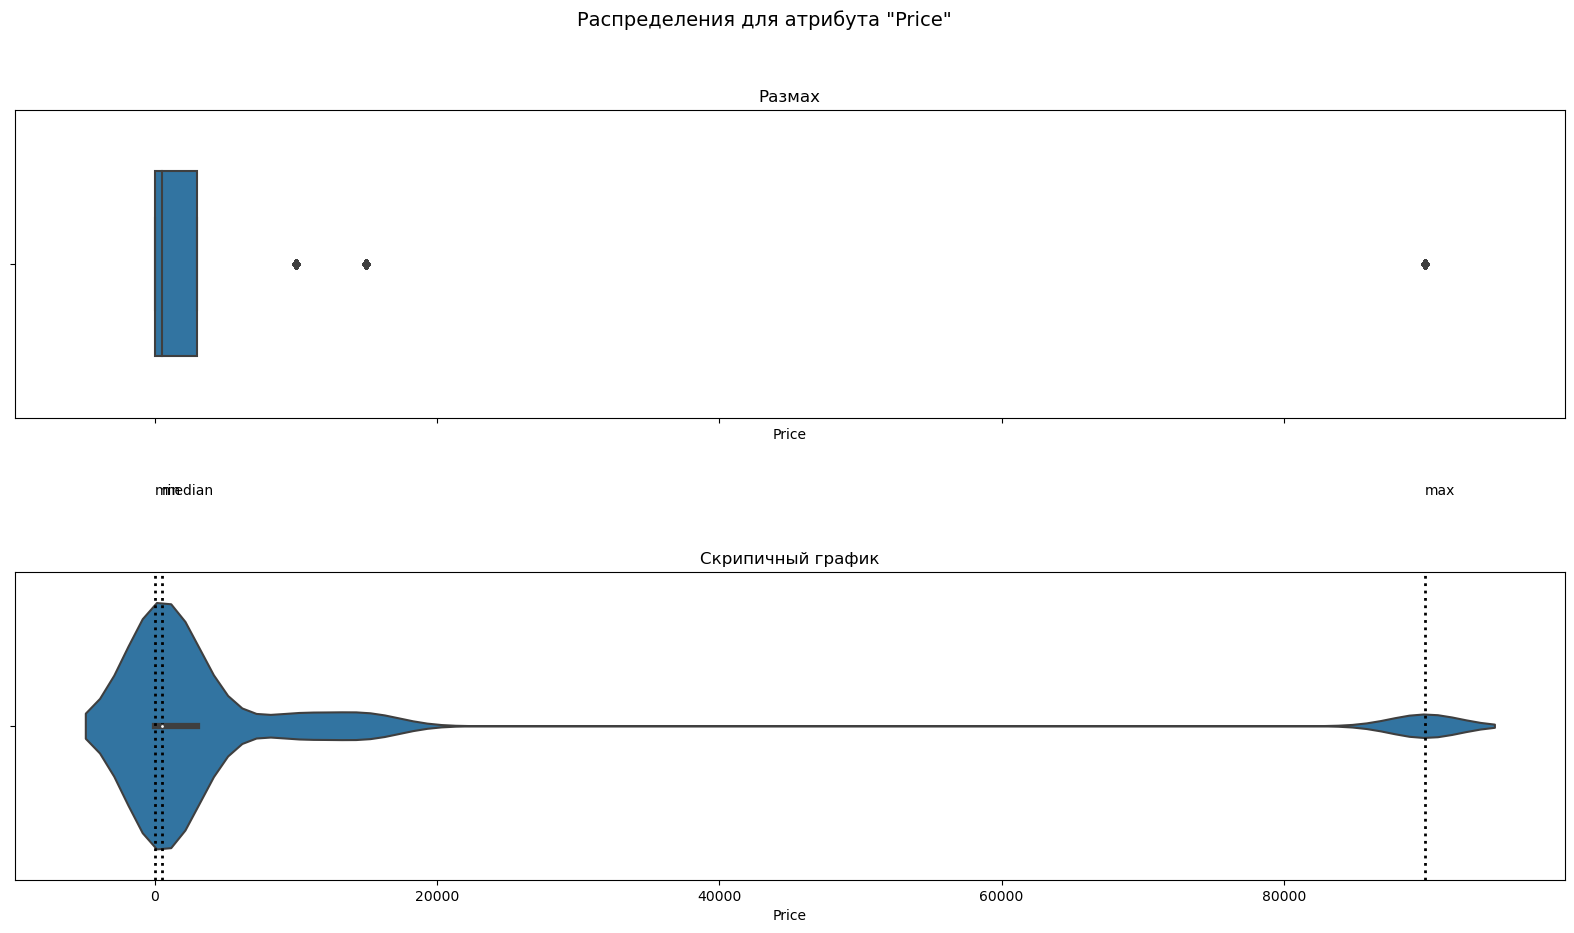

In [30]:
fig, ax = plt.subplots(2, 1, figsize = (20, 10), sharex = True)
fig.suptitle('Распределения для атрибута "Price"', fontsize = 14)
fig.subplots_adjust(hspace = 0.5)
    
sns.boxplot(data = df_new, x = 'Price', width=0.6, ax = ax[0])
ax[0].text(df_new['Price'].median(), 0.75,  'median')
ax[0].text(df_new['Price'].min(), 0.75,  'min')
ax[0].text(df_new['Price'].max(), 0.75,  'max')
ax[0].set_title('Размах', fontsize = 12)

sns.violinplot(data = df_new, x = 'Price', fill=False, ax = ax[1])
ax[1].axvline(df_new['Price'].median(), color = 'black', linestyle = 'dotted', linewidth = 2)
ax[1].axvline(df_new['Price'].min(), color = 'black', linestyle = 'dotted', linewidth = 2)
ax[1].axvline(df_new['Price'].max(), color = 'black', linestyle = 'dotted', linewidth = 2)
ax[1].set_title('Скрипичный график', fontsize = 12)
plt.show()

3. Используя интерквартильный размах, определяем границы для нормальных значений стоимости и выводим количество выбросов.

In [31]:
def outlines(data):
    q25 = data.quantile(0.25)
    q75 = data.quantile(0.75)
    iqr = q75 - q25
    boundaries = (q25 - 1.5 * iqr , q75 + 1.5 * iqr)
    
    return boundaries

In [32]:
boundaries = outlines(df_new['Price'])
print(f'Границы для нормальных значений стоимости: {boundaries}')

Границы для нормальных значений стоимости: (-4375.0, 7425.0)


In [33]:
outlines_number = (df_new['Price'] < boundaries[0]) | (df_new['Price'] > boundaries[1])
print(f'Количество выбросов: {outlines_number.sum()}')

Количество выбросов: 13994


4. Для целей оценки все выбросы в стоимости заменим на верхнюю границу нормальных значений, т.к. все выбросы находятся выше максимального. Выведем итоговую гистограмму.

In [34]:
df_new.loc[outlines_number,'Price'] = int(boundaries[1])

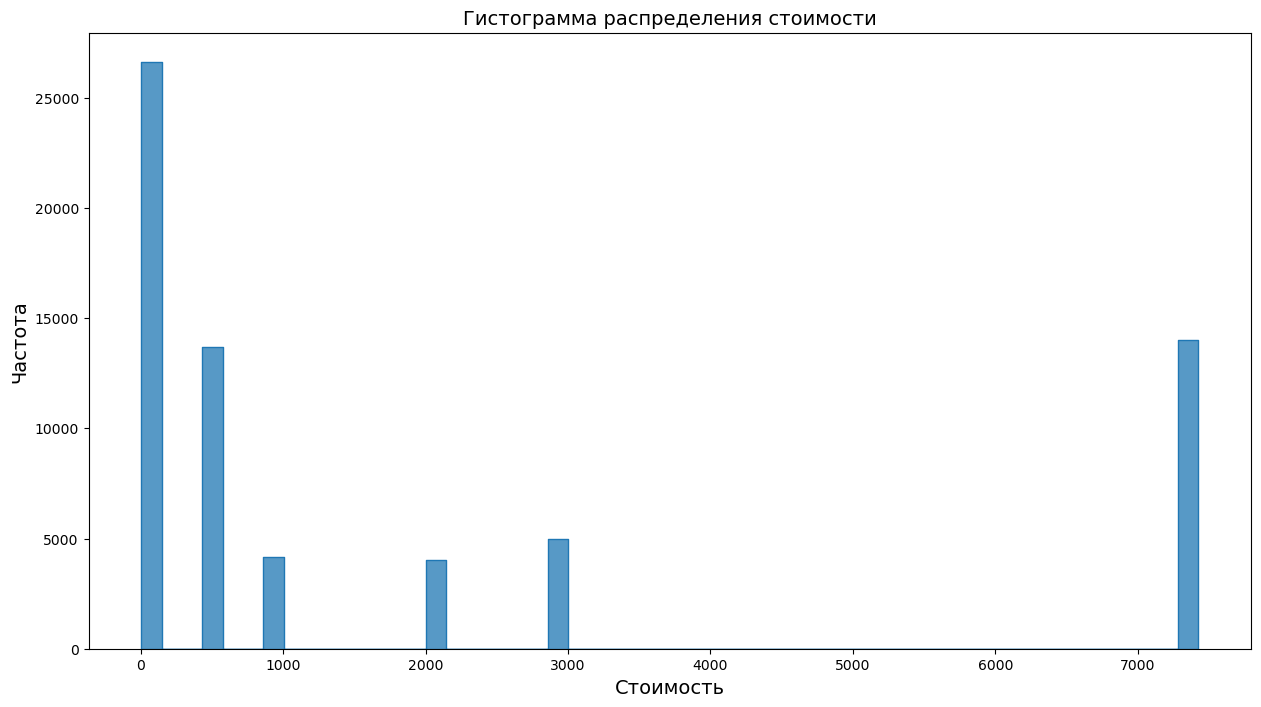

In [35]:
fig, ax = plt.subplots(figsize = (15, 8))

sns.histplot(df_new, x="Price", element = 'step')
ax.set_title('Гистограмма распределения стоимости', fontsize = 14)
ax.set_xlabel('Стоимость', fontsize = 14)
ax.set_ylabel('Частота', fontsize = 14)
plt.show()

## 4. Feature Engineering

### 4.1 Преобразование качественных переменных

1. Для категориальных переменных рассчитаем количество уникальных значений. 

In [36]:
categories = [
    'payment_method', 
    'is_completed_flg',
    'last_name',
    'first_name',
    'middle_name',
    'address',
    'device_name',
    'product_group_name',
    'product_name'
]

for title in categories:
    print('Наименование категории:', title)
    print('Кол-во уникальных значений:', df_new[title].nunique())
    print('\t')

Наименование категории: payment_method
Кол-во уникальных значений: 2
	
Наименование категории: is_completed_flg
Кол-во уникальных значений: 2
	
Наименование категории: last_name
Кол-во уникальных значений: 328
	
Наименование категории: first_name
Кол-во уникальных значений: 128
	
Наименование категории: middle_name
Кол-во уникальных значений: 140
	
Наименование категории: address
Кол-во уникальных значений: 316
	
Наименование категории: device_name
Кол-во уникальных значений: 5
	
Наименование категории: product_group_name
Кол-во уникальных значений: 4
	
Наименование категории: product_name
Кол-во уникальных значений: 15
	


2. Исходя из проведённого анализа важности фичей, атрибуты `last_name`, `first_name` и `middle_name` следует удалить, как менее влияющие на результаты прогноза модели. Для атрибутов `payment_method` и `is_completed_flg` перекодируем уникальные значения OrdinalEncoding. Для всех остальных используем OneHotEncoding

In [37]:
ore_data = df_new[categories[:2]]

ore = OrdinalEncoder()
ore.fit(ore_data)
ore_categories = ore.transform(ore_data)
df_new[['payment_method_trf', 'is_completed_flg_trf']] = ore_categories

ohe_data = df_new[categories[5:]]

ohe = OneHotEncoder(sparse = False)
ohe.fit(ohe_data)
ohe_categories = ohe.transform(ohe_data)
df_ohe = pd.DataFrame(ohe_categories, columns = ohe.get_feature_names_out())
df_new = pd.concat([df_new, df_ohe] , axis = 1)

df_new.head()

,order_id,customer_id,order_dt,payment_method,delivery_id,delivery_dt,is_completed_flg,last_name,first_name,middle_name,...,product_name_Огурец,product_name_Рубашка,product_name_Сок,product_name_Хлеб,product_name_Часы напольные,product_name_Часы наручные,product_name_Часы настенные,product_name_Часы с кукушкой,product_name_Штаны,product_name_Юбка
0,99983,4951223,2021-12-07 00:00:00+00:00,offline,81,2022-01-17 00:00:00+00:00,True,Андреев,Михаил,Глебович,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,99983,4951223,2021-12-07 00:00:00+00:00,offline,81,2022-01-17 00:00:00+00:00,True,Андреев,Михаил,Глебович,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,99983,4951223,2021-12-07 00:00:00+00:00,offline,81,2022-01-17 00:00:00+00:00,True,Андреев,Михаил,Глебович,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,99983,4951223,2021-12-07 00:00:00+00:00,offline,81,2022-01-17 00:00:00+00:00,True,Андреев,Михаил,Глебович,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,99983,4951223,2021-12-07 00:00:00+00:00,offline,81,2022-01-17 00:00:00+00:00,True,Андреев,Михаил,Глебович,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


3. Сохраним исходные атрибуты для последующего удаления

In [38]:
clms_to_drop = [] 
clms_to_drop = categories

### 4.2 Создание новых признаков на основе информации в датафрейме

1. Создадим признаки `month`, `day`, `year`, `dayofweek` и др. на основании данных по датам

In [39]:
def date_transform(df, atrb_list):
    for title in atrb_list:
        df[str(title + '_' + 'month')] = df[title].dt.month
        df[str(title + '_' + 'day')] = df[title].dt.day
        df[str(title + '_' + 'year')] = df[title].dt.year
        df[str(title + '_' + 'dayofweek')] = df[title].dt.dayofweek
    
    dlv_diff = df[atrb_list[1]] - df[atrb_list[0]]
    sess_diff = df[atrb_list[4]] - df[atrb_list[3]]
    
    df['dlv_diff_days'] = dlv_diff.apply(lambda x: x.days)
    df['sess_diff_sec'] = sess_diff.apply(lambda x: x.seconds)

In [40]:
date_list = [
    'order_dt',
    'delivery_dt', 
    'birth_dt', 
    'start_dttm', 
    'finish_dttm'
] 

date_transform(df_new, date_list)

2. Сохраним исходные атрибуты для последующего удаления

In [41]:
for date in date_list:
    clms_to_drop.append(date)

3. Гистограммы распределения по атрибутам `dlv_diff_days` и `sess_diff_sec`

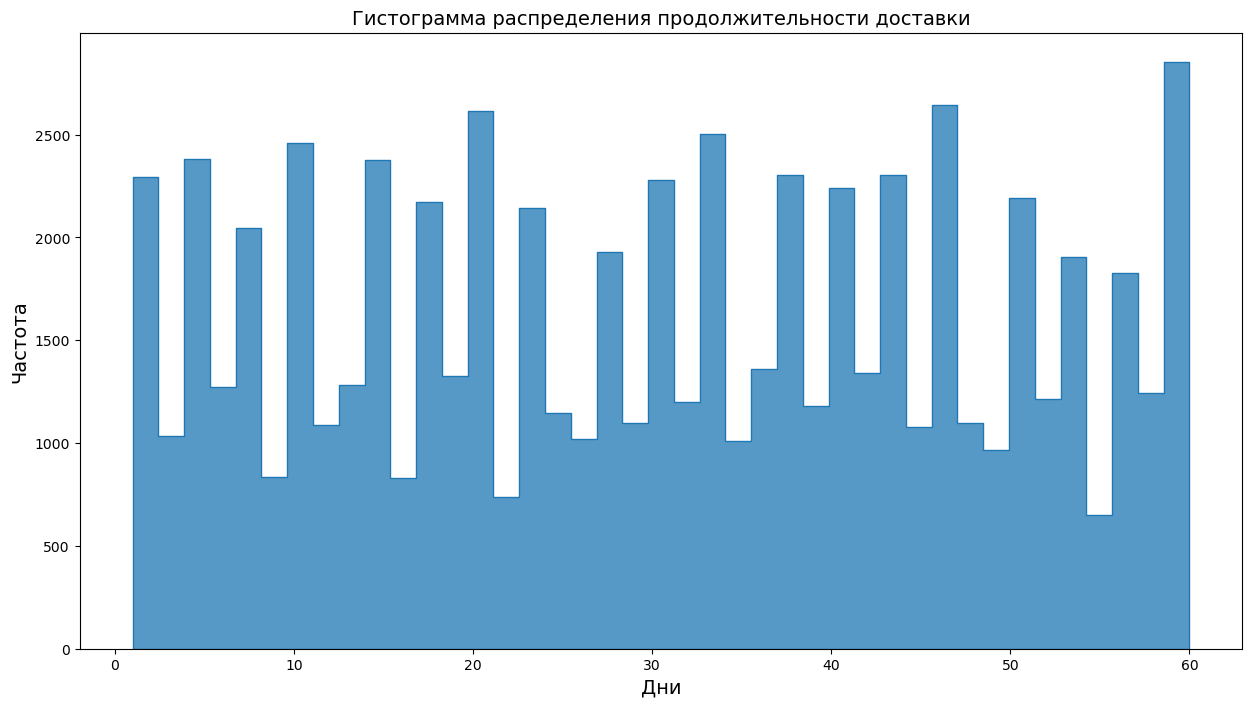

In [42]:
fig, ax = plt.subplots(figsize = (15, 8))

sns.histplot(df_new, x="dlv_diff_days", element = 'step')
ax.set_title('Гистограмма распределения продолжительности доставки', fontsize = 14)
ax.set_xlabel('Дни', fontsize = 14)
ax.set_ylabel('Частота', fontsize = 14)
plt.show()

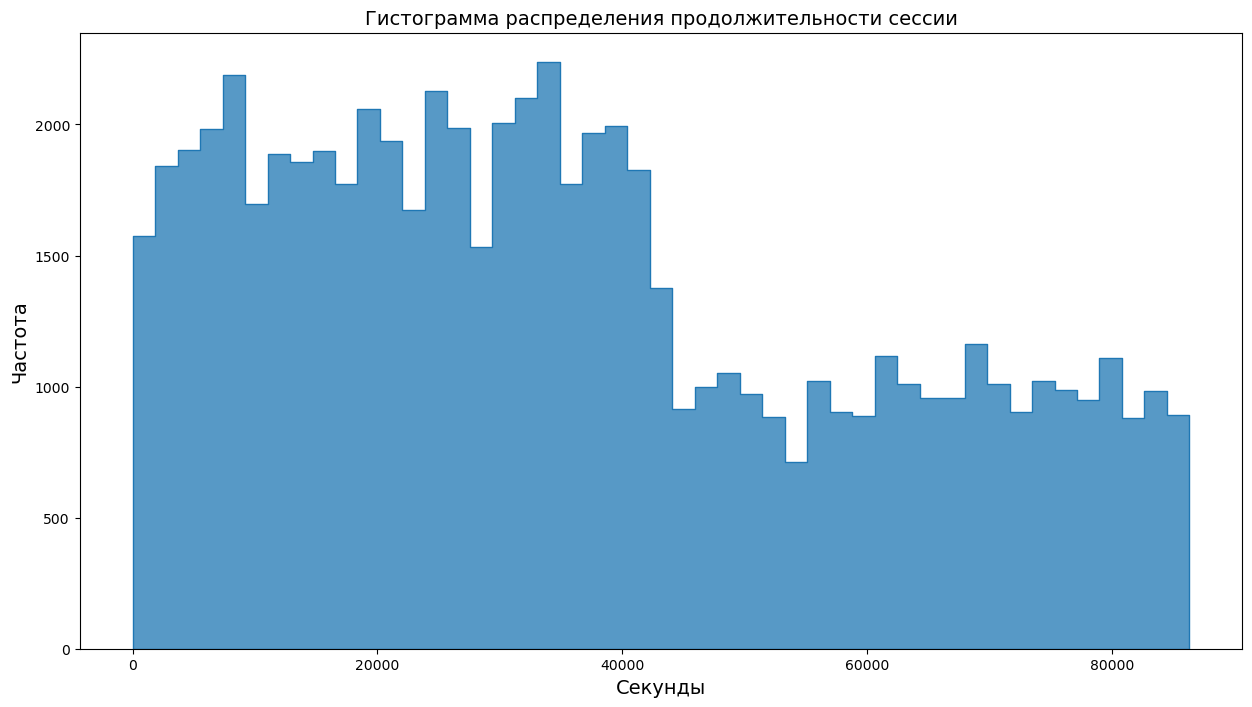

In [43]:
fig, ax = plt.subplots(figsize = (15, 8))

sns.histplot(df_new, x="sess_diff_sec", element = 'step')
ax.set_title('Гистограмма распределения продолжительности сессии', fontsize = 14)
ax.set_xlabel('Секунды', fontsize = 14)
ax.set_ylabel('Частота', fontsize = 14)
plt.show()

### 4.3 Стандартизация и нормализация количественных переменных

1. Для всех количественных переменных выполним стандартизацию и нормализацию с помощью StandardScaler и MinMaxScaler. Атрибут `dlv_diff_days` явялется целевой переменной, поэтому преобразования к нему не применяются.

In [44]:
num_cat = ['amount', 
           'Price',
           'order_dt_month',
           'order_dt_day',
           'order_dt_year',
           'order_dt_dayofweek',
           'delivery_dt_month',
           'delivery_dt_day',
           'delivery_dt_year',
           'delivery_dt_dayofweek',
           'birth_dt_month',
           'birth_dt_day',
           'birth_dt_year',
           'birth_dt_dayofweek',
           'start_dttm_month',
           'start_dttm_day',
           'start_dttm_year',
           'start_dttm_dayofweek',
           'finish_dttm_month',
           'finish_dttm_day',
           'finish_dttm_year',
           'finish_dttm_dayofweek',
           'sess_diff_sec'
          ]
num_cat_scc = []
num_cat_mmsc = []
data_num = df_new[num_cat]

ssc = StandardScaler()
ssc.fit(data_num)
ssc_num_cat = ssc.transform(data_num)
for i in range(len(num_cat)):
    num_cat_scc.append(str(num_cat[i] + '_' + 'scc'))
df_new[num_cat_scc] = ssc_num_cat

mmsc = MinMaxScaler()
mmsc.fit(data_num)
for i in range(len(num_cat)):
    num_cat_mmsc.append(str(num_cat[i] + '_' + 'mmsc'))
mmsc_num_cat = mmsc.transform(data_num)
df_new[num_cat_mmsc] = mmsc_num_cat

2. Выведем матрицу корреляций для всех количественных признаков, чтобы убедиться, что нормализация признаков сохранила свойства исходных признаков.

In [45]:
attribute = df_new.filter(['amount', 'Price'] + num_cat_scc + num_cat_mmsc)

attribute.corr(method = 'pearson')

,amount,Price,amount_scc,Price_scc,order_dt_month_scc,order_dt_day_scc,order_dt_year_scc,order_dt_dayofweek_scc,delivery_dt_month_scc,delivery_dt_day_scc,...,birth_dt_dayofweek_mmsc,start_dttm_month_mmsc,start_dttm_day_mmsc,start_dttm_year_mmsc,start_dttm_dayofweek_mmsc,finish_dttm_month_mmsc,finish_dttm_day_mmsc,finish_dttm_year_mmsc,finish_dttm_dayofweek_mmsc,sess_diff_sec_mmsc
amount,1.000000,-0.017088,1.000000,-0.017088,0.009843,-0.009945,-0.008243,0.013668,0.017324,-0.023590,...,0.028803,-0.000253,0.018777,-0.014153,-0.008536,-0.000250,0.011194,-0.013903,-0.023133,-0.001522
Price,-0.017088,1.000000,-0.017088,1.000000,-0.004494,-0.033634,0.009642,-0.013112,-0.004842,-0.012552,...,0.009244,-0.037770,0.002054,-0.010669,-0.022428,-0.036897,-0.003454,-0.010746,-0.016536,-0.001262
amount_scc,1.000000,-0.017088,1.000000,-0.017088,0.009843,-0.009945,-0.008243,0.013668,0.017324,-0.023590,...,0.028803,-0.000253,0.018777,-0.014153,-0.008536,-0.000250,0.011194,-0.013903,-0.023133,-0.001522
Price_scc,-0.017088,1.000000,-0.017088,1.000000,-0.004494,-0.033634,0.009642,-0.013112,-0.004842,-0.012552,...,0.009244,-0.037770,0.002054,-0.010669,-0.022428,-0.036897,-0.003454,-0.010746,-0.016536,-0.001262
order_dt_month_scc,0.009843,-0.004494,0.009843,-0.004494,1.000000,-0.025841,-0.234272,-0.002151,0.540346,-0.010570,...,-0.072935,0.128651,-0.031002,0.035080,0.026932,0.141026,-0.014463,0.031172,-0.010096,-0.011525
order_dt_day_scc,-0.009945,-0.033634,-0.009945,-0.033634,-0.025841,1.000000,0.035571,-0.007338,0.008962,-0.037357,...,-0.030161,0.034693,0.142318,0.008534,-0.007021,0.044346,0.155682,0.005510,0.030450,0.002669
order_dt_year_scc,-0.008243,0.009642,-0.008243,0.009642,-0.234272,0.035571,1.000000,0.006819,-0.134250,-0.022086,...,0.059828,-0.016449,0.036425,0.148428,-0.003802,-0.027970,0.021809,0.151218,0.037245,0.004952
order_dt_dayofweek_scc,0.013668,-0.013112,0.013668,-0.013112,-0.002151,-0.007338,0.006819,1.000000,0.019714,-0.018225,...,0.040625,0.032140,-0.002714,-0.020211,0.013988,0.018248,-0.021524,-0.015840,0.092390,0.009818
delivery_dt_month_scc,0.017324,-0.004842,0.017324,-0.004842,0.540346,0.008962,-0.134250,0.019714,1.000000,-0.006026,...,-0.014058,0.056166,-0.032660,0.048925,0.072161,0.065525,-0.027202,0.045997,0.054684,-0.004496
delivery_dt_day_scc,-0.023590,-0.012552,-0.023590,-0.012552,-0.010570,-0.037357,-0.022086,-0.018225,-0.006026,1.000000,...,0.025982,0.023719,0.003357,-0.004710,-0.012977,0.024364,0.010225,-0.005007,-0.013125,0.004774


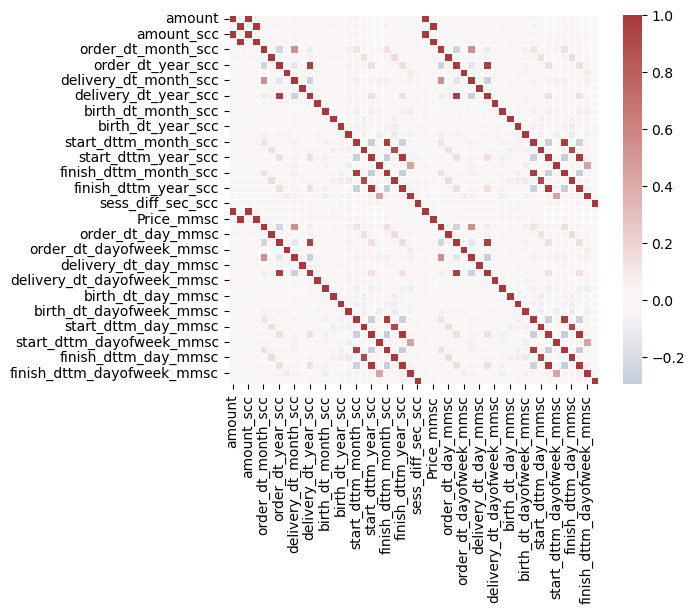

In [46]:
sns.heatmap(attribute.corr(method = 'pearson'), cmap = 'vlag' , center = 0 , square = True, linewidths = 0.5)
plt.show()

3. Сохраним атрибуты для последующего удаления

In [47]:
for i in num_cat:
    clms_to_drop.append(i)

for j in num_cat_mmsc:
    clms_to_drop.append(j)

### 4.4 Удаление неинформативных колонок и формирование финального датасета

1. Удалим колонки, которые были исходными для формирования признаков, а также дополнительные колонки. Сохраним новый датафрейм в переменную `df_prep`

In [48]:
df_prep = df_new.drop(columns = clms_to_drop)

print(f'Размерность финального датасета {df_prep.shape}')

Размерность финального датасета (67467, 372)


## 5. Modeling

### 5.1 Формирование датасета для обучения

1. Сформируем финальный датасет для обучения. Инициализируем фичи и целевую переменную. 

Атрибуты, включающие в себя ID, и атрибуты по `birth_dt`, а также `phone_number` удаляем, т.к. они влияют на целевую переменную в меньшей степени. Атрибуты, связанные с `delivery_dt`, удаляем, т.к. дата доставки на этапе прогнозирования неизвестна.

In [49]:
df_final = df_prep.drop([
    'order_id',
    'phone_number',
    'customer_id',
    'delivery_id',
    'session_id',
    'product_id',
    'birth_dt_month_scc',
    'birth_dt_day_scc',
    'birth_dt_year_scc',
    'birth_dt_dayofweek_scc',
    'delivery_dt_month_scc',
    'delivery_dt_day_scc',
    'delivery_dt_year_scc',
    'delivery_dt_dayofweek_scc'
], axis = 1)

x = df_final.drop(['dlv_diff_days'], axis = 1)
y = df_final['dlv_diff_days']

2. Разделим данные на тренировочную и тестовую выборку

In [50]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 42)

Учитывая, что целевая переменная является количественной, тип прогнозирования относится к задаче регрессии. Качество предикта будет оцениваться по метрике MAE, MAPE и R2.

### 5.2 Обучение модели случайного леса

1. Инициализируем модель случайного леса с зафиксированным параметром `random_state` = 42 для воспроизводимости результата. Обучим модель на тренировочной выборке.

In [51]:
rf_regr = RandomForestRegressor(
    n_jobs = -1,
    random_state = 42
)

rf_regr.fit(x_train, y_train)

RandomForestRegressor(n_jobs=-1, random_state=42)

2. Сделаем предикт на тестовой выборке и выведем метрики качества.

In [52]:
predicted_test_rf = rf_regr.predict(x_test)

print(f'Метрика MAE: {mean_absolute_error(y_test, predicted_test_rf)}')
print(f'Метрика MAPE: {mean_absolute_percentage_error(y_test, predicted_test_rf)}')
print(f'Метрика R2: {r2_score(y_test, predicted_test_rf)}')

Метрика MAE: 6.3963924784408706
Метрика MAPE: 0.6006278963188872
Метрика R2: 0.5137657947260261


3. Параметры текущей модели и коэффициенты важности фичей c графиком

In [53]:
rf_regr.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

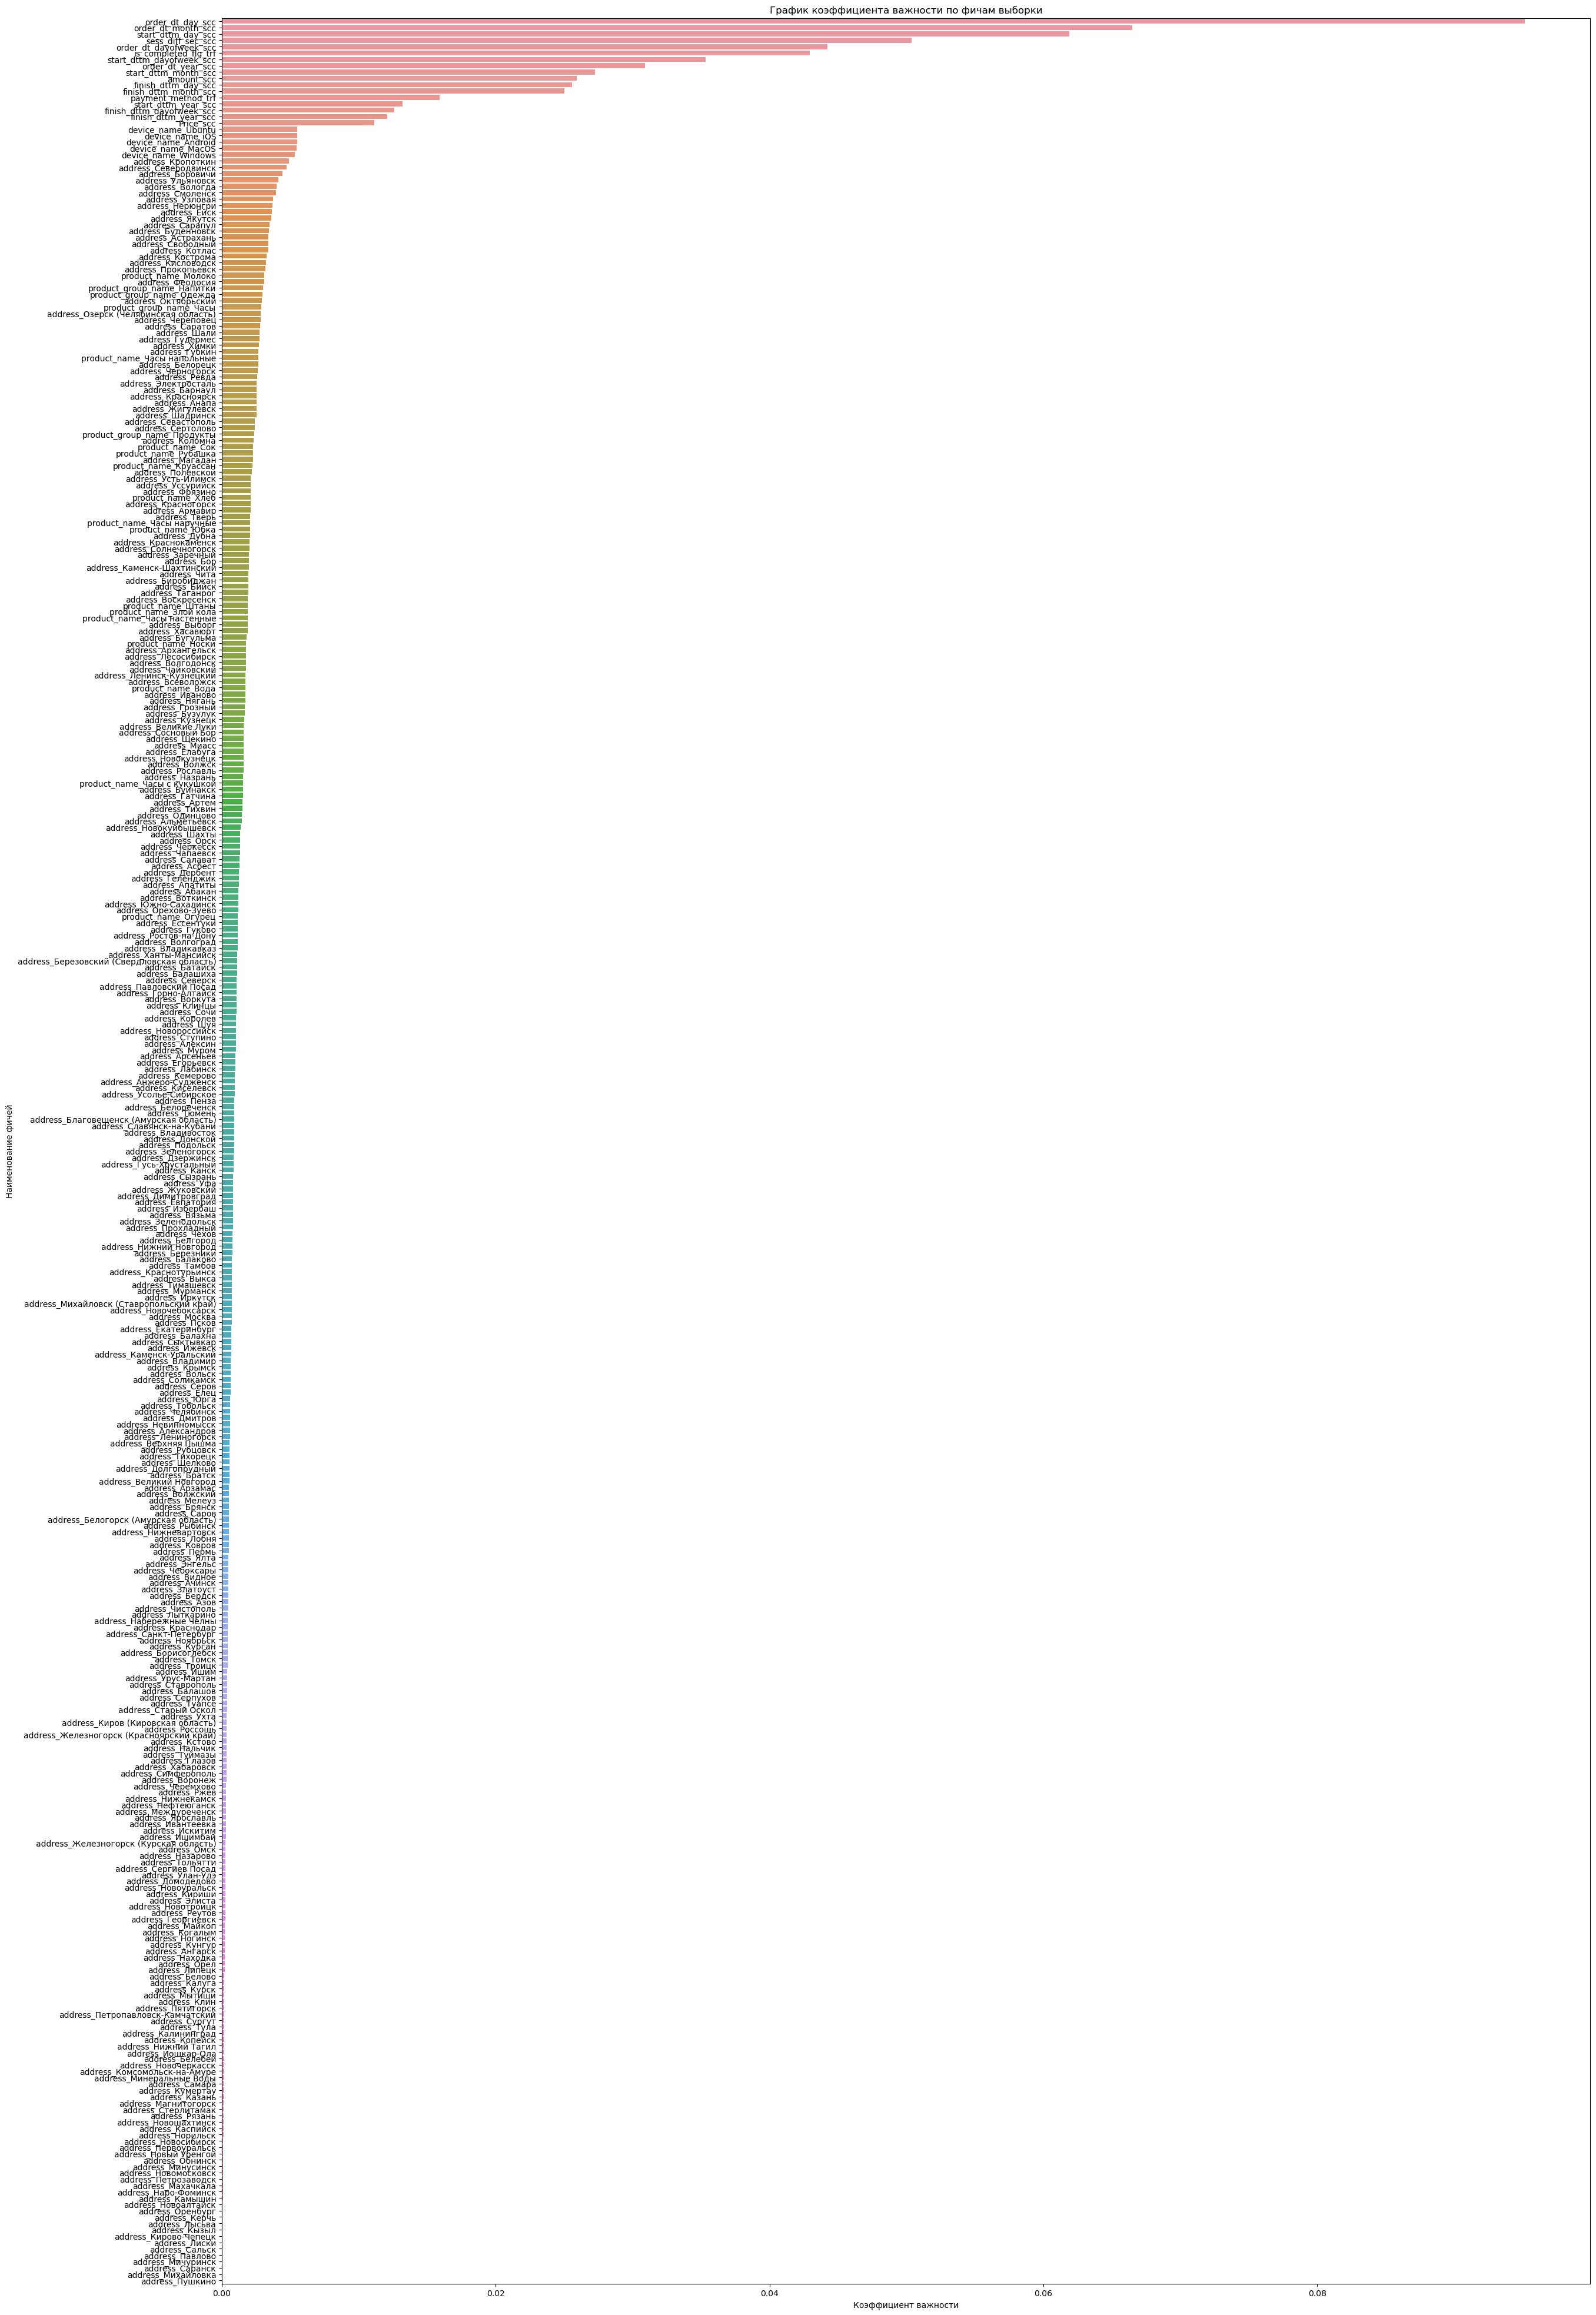

In [54]:
importances_rf = rf_regr.feature_importances_
feature_names = x.columns

rf_regr_importances = pd.Series(importances_rf , index = feature_names).sort_values(ascending = False).round(5)

plt.figure(figsize = (30,50))
sns.barplot(x = rf_regr_importances.values, y = rf_regr_importances.index, orient = "h")
plt.xlabel('Коэффициент важности')
plt.ylabel('Наименование фичей')
plt.title('График коэффициента важности по фичам выборки')
plt.show()

4. Увеличим точность модели с помощью тюнинга параметров. Воспользуемся RandomizedSearchCV

In [66]:
param_grid = {
    'n_estimators' : list(range(100, 1001, 50)),
    'max_features' : ['sqrt'],
    'max_depth' : list(range(100, 301, 50)),
    'min_samples_leaf' : list(range(1, 21, 2)),
    'min_samples_split' : list(range(2, 21, 2)),
} 

In [67]:
%%time
rscv_rf = RandomizedSearchCV(
    estimator = rf_regr,
    param_distributions = param_grid,
    n_iter = 20,
    cv = 5,
    scoring = 'neg_mean_absolute_error',
    verbose = 1,
    n_jobs = -1
)

rscv_rf.fit(x_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Wall time: 23min 53s


RandomizedSearchCV(cv=5,
                   estimator=RandomForestRegressor(n_jobs=-1, random_state=42),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'max_depth': [100, 150, 200, 250, 300],
                                        'max_features': ['sqrt'],
                                        'min_samples_leaf': [1, 3, 5, 7, 9, 11,
                                                             13, 15, 17, 19],
                                        'min_samples_split': [2, 4, 6, 8, 10,
                                                              12, 14, 16, 18,
                                                              20],
                                        'n_estimators': [100, 150, 200, 250,
                                                         300, 350, 400, 450,
                                                         500, 550, 600, 650,
                                                         700, 750, 800, 850,
                   

In [68]:
best_params = rscv_rf.best_params_
best_params

{'n_estimators': 500,
 'min_samples_split': 8,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 300}

In [55]:
rf_regr_tuned = RandomForestRegressor(
    n_estimators = 500,
    min_samples_split = 8,
    min_samples_leaf = 1,
    max_depth = 300,
    max_features = 'auto',  
    n_jobs = -1,
    random_state = 42
)

rf_regr_tuned.fit(x_train, y_train)
predicted_test_rf_tuned = rf_regr_tuned.predict(x_test)

print(f'Метрика MAE: {mean_absolute_error(y_test, predicted_test_rf_tuned)}')
print(f'Метрика MAPE: {mean_absolute_percentage_error(y_test, predicted_test_rf_tuned)}')
print(f'Метрика R2: {r2_score(y_test, predicted_test_rf_tuned)}')

Метрика MAE: 5.698510837441719
Метрика MAPE: 0.5336963479345274
Метрика R2: 0.6230276110932123


По метрикам MAE, MAPE и R2 тюнингованная модель показывает лучшие результаты

5. Выполним кросс - валидацию получившейся модели на тренировочной выборке.

In [56]:
cross_validate(rf_regr_tuned, x_train, y_train, n_jobs = -1, cv = 5)

{'fit_time': array([793.56514168, 812.39083695, 807.38525748, 789.70602179,
        814.42108178]),
 'score_time': array([4.40496397, 0.56550813, 2.34668565, 4.3665936 , 0.37095881]),
 'test_score': array([0.63792258, 0.6444838 , 0.63131661, 0.64104477, 0.65153412])}

6. Определяем среднее значение результатов кросс - валидации и стандартное отклонение.

In [57]:
rf_regr_cv_score = cross_val_score(rf_regr_tuned, x_train, y_train, n_jobs = -1, cv = 5)

print(f'Среднее значение результатов кросс - валидации: {rf_regr_cv_score.mean()}')
print(f'Стандартное отклонение результатов кросс - валидации: {rf_regr_cv_score.std()}')

Среднее значение результатов кросс - валидации: 0.6412603756106812
Стандартное отклонение результатов кросс - валидации: 0.006723184514977718


**Вывод:** модель не переобучилась.

### 5.3 Обучение модели дерева решений

1. Инициализируем модель дерева решений с зафиксированным параметром `random_state` = 42 для воспроизводимости результата. Обучим модель на тренировочной выборке.

In [58]:
dt_regr = DecisionTreeRegressor(
    random_state = 42
)

dt_regr.fit(x_train, y_train)

DecisionTreeRegressor(random_state=42)

2. Сделаем предикт на тестовой выборке и выведем метрики качества.

In [59]:
predicted_test_dt = dt_regr.predict(x_test)

print(f'Метрика MAE: {mean_absolute_error(y_test, predicted_test_dt)}')
print(f'Метрика MAPE: {mean_absolute_percentage_error(y_test, predicted_test_dt)}')
print(f'Метрика R2: {r2_score(y_test, predicted_test_dt)}')

Метрика MAE: 7.213638160169952
Метрика MAPE: 0.6800098989783487
Метрика R2: 0.3113983437834359


3. Параметры текущей модели и коэффициенты важности фичей c графиком

In [60]:
dt_regr.get_params()

{'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': 42,
 'splitter': 'best'}

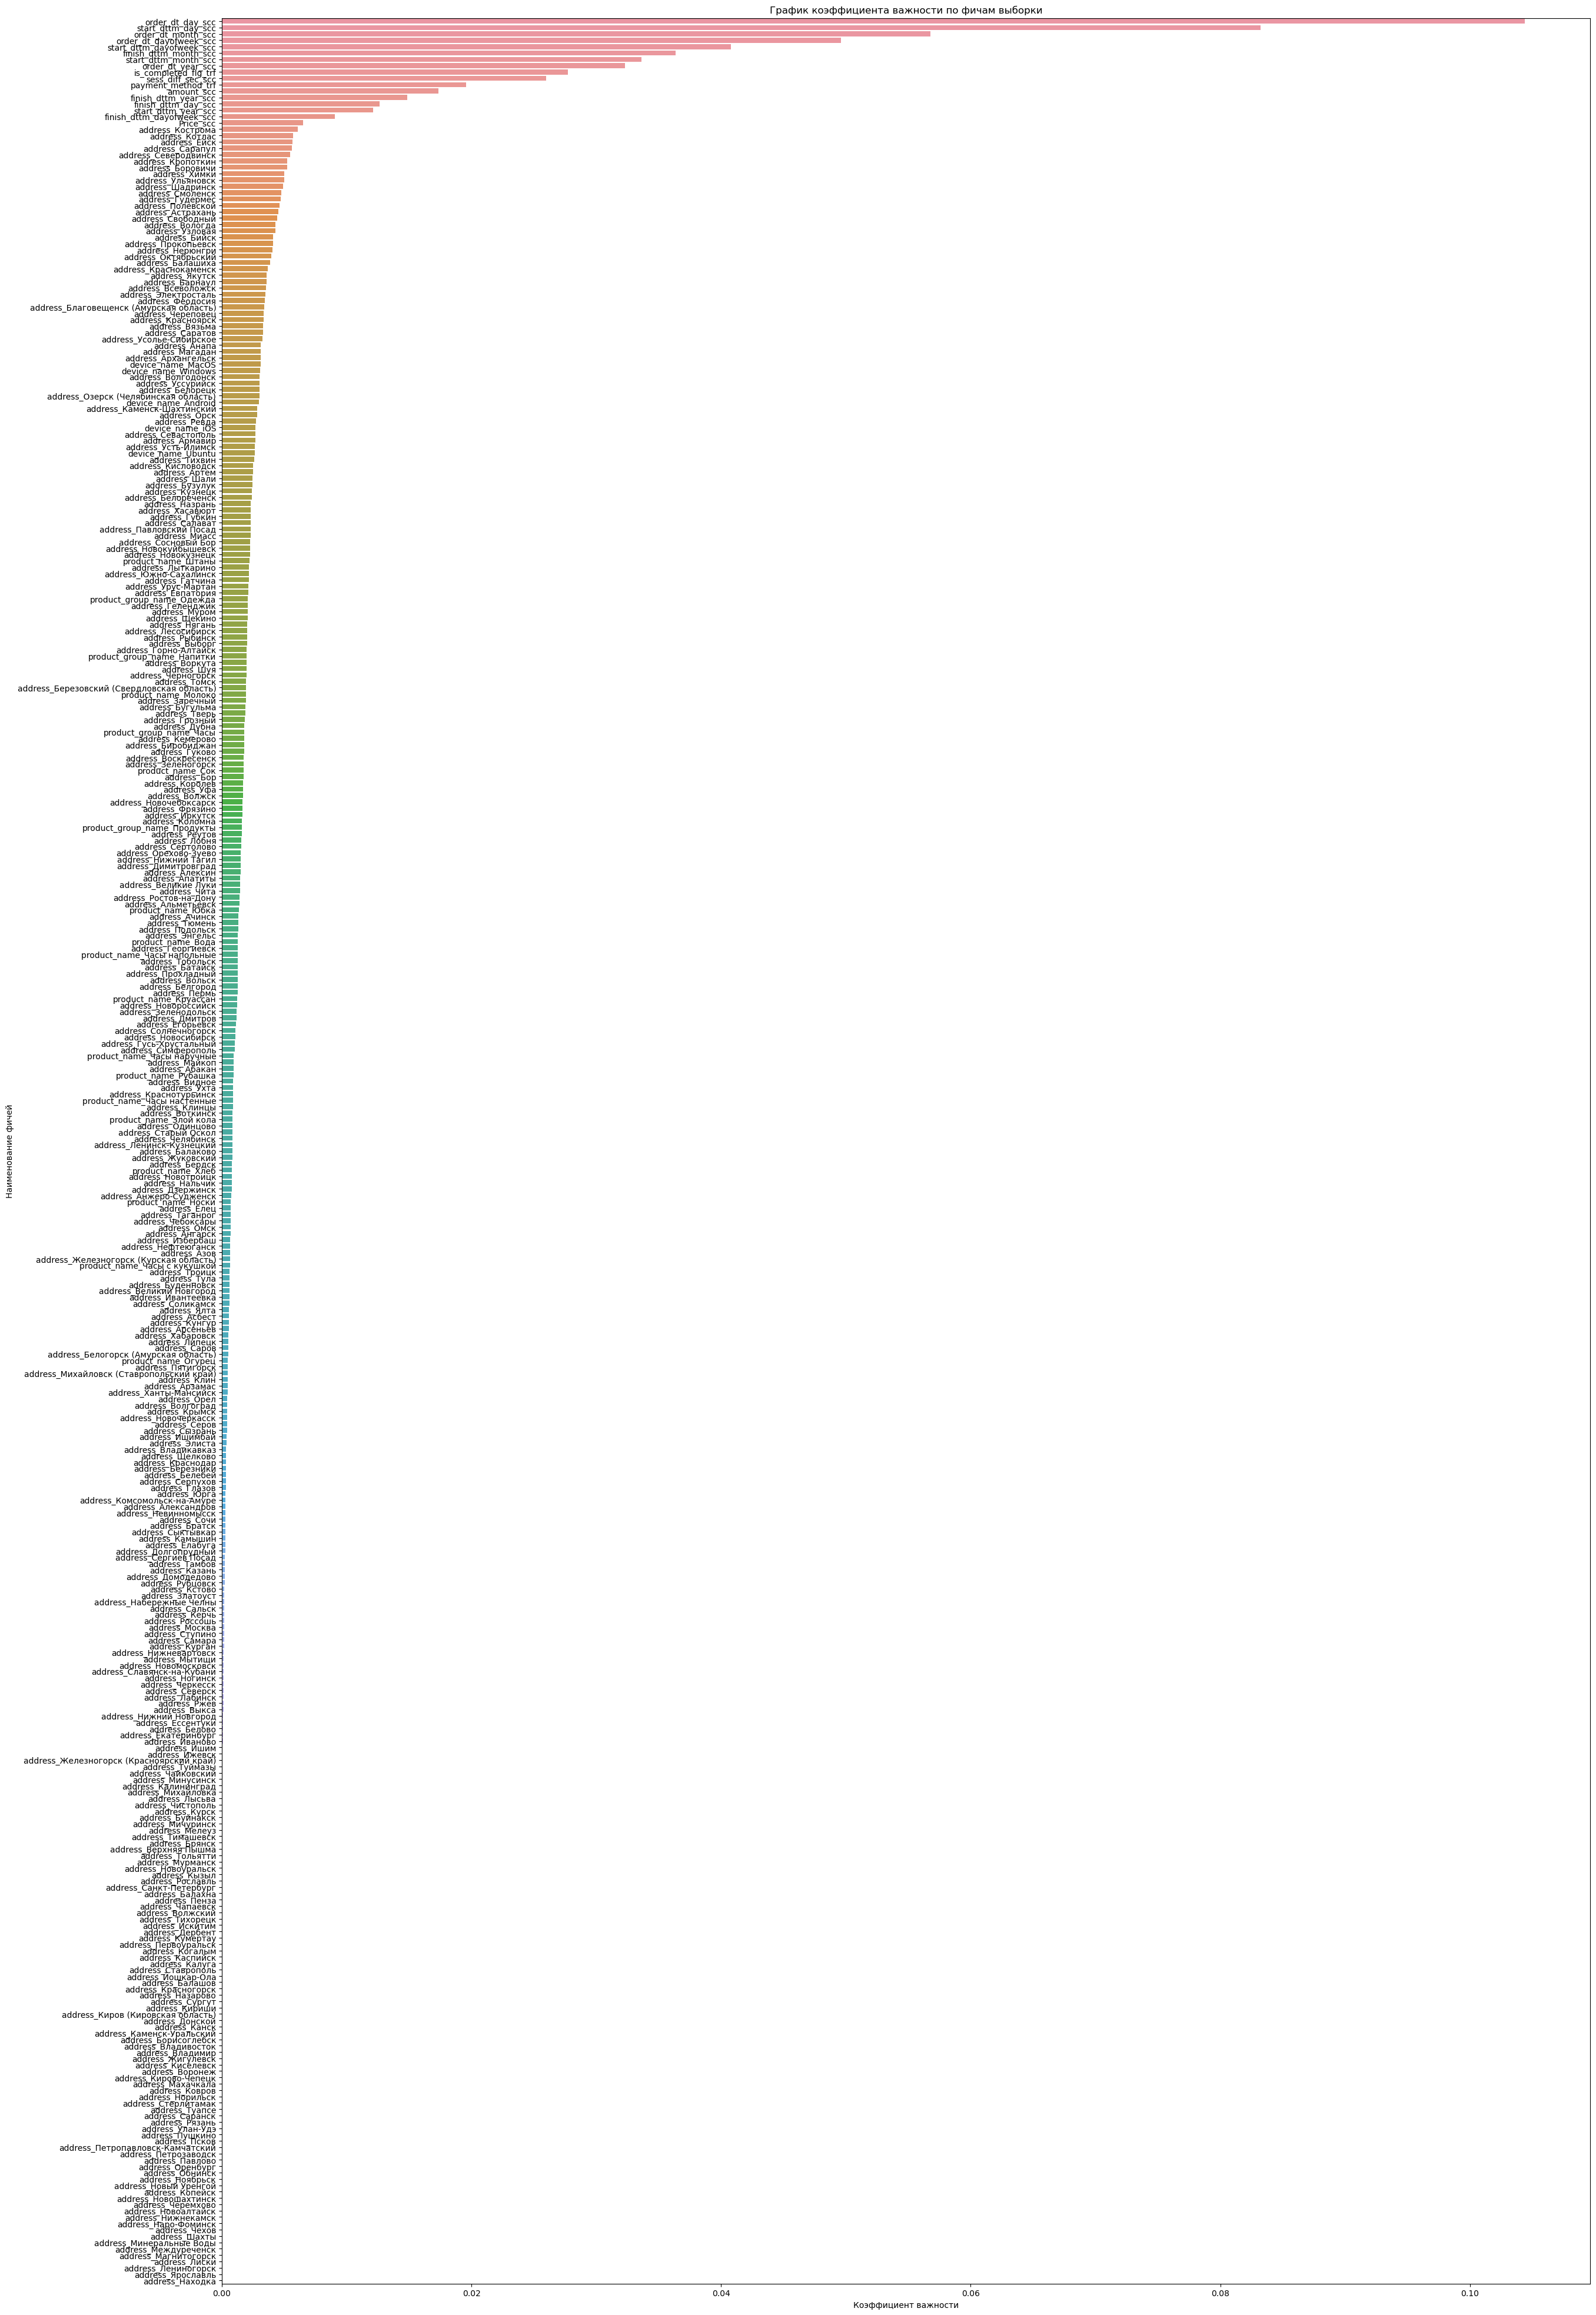

In [61]:
importances_dt = dt_regr.feature_importances_

dt_regr_importances = pd.Series(importances_dt , index = feature_names).sort_values(ascending = False).round(5)

plt.figure(figsize = (30,50))
sns.barplot(x = dt_regr_importances.values, y = dt_regr_importances.index, orient = "h")
plt.xlabel('Коэффициент важности')
plt.ylabel('Наименование фичей')
plt.title('График коэффициента важности по фичам выборки')
plt.show()

4. Увеличим точность модели с помощью тюнинга параметров. Воспользуемся RandomizedSearchCV

In [86]:
param_grid = {
    'splitter' : ['best', 'random'],
    'max_depth' : list(range(100, 301, 50)),
    'min_samples_split' : list(range(2, 21, 2)),
    'min_samples_leaf' : list(range(1, 21, 2)),
    'max_features' : ['sqrt', 'auto', 'log2']
}

In [87]:
%%time
rscv_dt = RandomizedSearchCV(
    estimator = dt_regr,
    param_distributions = param_grid,
    n_iter = 20,
    cv = 5,
    scoring = 'neg_mean_absolute_error',
    verbose = 1,
    n_jobs = -1
)

rscv_dt.fit(x_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Wall time: 28.7 s


RandomizedSearchCV(cv=5, estimator=DecisionTreeRegressor(random_state=42),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'max_depth': [100, 150, 200, 250, 300],
                                        'max_features': ['sqrt', 'auto',
                                                         'log2'],
                                        'min_samples_leaf': [1, 3, 5, 7, 9, 11,
                                                             13, 15, 17, 19],
                                        'min_samples_split': [2, 4, 6, 8, 10,
                                                              12, 14, 16, 18,
                                                              20],
                                        'splitter': ['best', 'random']},
                   scoring='neg_mean_absolute_error', verbose=1)

In [88]:
best_params = rscv_dt.best_params_
best_params

{'splitter': 'random',
 'min_samples_split': 14,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 300}

In [62]:
dt_regr_tuned = DecisionTreeRegressor(
    splitter = 'random',
    min_samples_split = 14,
    min_samples_leaf = 1,
    max_depth = 300,
    max_features = 'auto',  
    random_state = 42
)

dt_regr_tuned.fit(x_train, y_train)
predicted_test_dt_tuned = dt_regr_tuned.predict(x_test)

print(f'Метрика MAE: {mean_absolute_error(y_test, predicted_test_dt_tuned)}')
print(f'Метрика MAPE: {mean_absolute_percentage_error(y_test, predicted_test_dt_tuned)}')
print(f'Метрика R2: {r2_score(y_test, predicted_test_dt_tuned)}')

Метрика MAE: 5.348997501765398
Метрика MAPE: 0.5015840124859341
Метрика R2: 0.6332072525782899


По метрикам MAE, MAPE и R2 тюнингованная модель показывает лучшие результаты

5. Выполним кросс - валидацию получившейся модели на тренировочной выборке.

In [63]:
cross_validate(dt_regr_tuned, x_train, y_train, n_jobs = -1, cv = 10)

{'fit_time': array([6.1487751 , 6.06072235, 6.62919641, 6.68851781, 5.8378005 ,
        4.39430761, 4.27796578, 3.69475389, 4.75749874, 3.5359385 ]),
 'score_time': array([0.01802063, 0.0189352 , 0.02016759, 0.02338243, 0.02036119,
        0.00999546, 0.00999761, 0.0150044 , 0.00901794, 0.01197958]),
 'test_score': array([0.64127225, 0.62121353, 0.62834719, 0.63612986, 0.62544467,
        0.61523924, 0.64786293, 0.63320093, 0.64628943, 0.63970193])}

6. Определяем среднее значение результатов кросс - валидации и стандартное отклонение.

In [64]:
dt_regr_cv_score = cross_val_score(dt_regr_tuned, x_train, y_train, n_jobs = -1, cv = 10)

print(f'Среднее значение результатов кросс - валидации: {dt_regr_cv_score.mean()}')
print(f'Стандартное отклонение результатов кросс - валидации: {dt_regr_cv_score.std()}')

Среднее значение результатов кросс - валидации: 0.6334701972766179
Стандартное отклонение результатов кросс - валидации: 0.010254680108021117


**Вывод:** модель не переобучилась, однако стандартное отклонение превышает значение других моделей. При этом среднее значение результатов кросс-валидации сопоставимо с моделью случайного леса.

### 5.4 Обучение модели линейной регрессии

1. Инициализируем модель линейной регрессии с зафиксированным параметром `random_state` = 42 для воспроизводимости результата. Обучим модель на тренировочной выборке.

In [65]:
ln_regr = LinearRegression(
    n_jobs = -1
)

ln_regr.fit(x_train, y_train)

LinearRegression(n_jobs=-1)

2. Сделаем предикт на тестовой выборке и выведем метрики качества.

In [66]:
predicted_test_lr = ln_regr.predict(x_test)

print(f'Метрика MAE: {mean_absolute_error(y_test, predicted_test_lr)}')
print(f'Метрика MAPE: {mean_absolute_percentage_error(y_test, predicted_test_lr)}')
print(f'Метрика R2: {r2_score(y_test, predicted_test_lr)}')

Метрика MAE: 13.58960907780001
Метрика MAPE: 1.4121084836066942
Метрика R2: 0.1336553557525446


3. Параметры текущей модели

In [67]:
ln_regr.get_params()

{'copy_X': True,
 'fit_intercept': True,
 'n_jobs': -1,
 'normalize': 'deprecated',
 'positive': False}

4. Увеличим точность модели с помощью тюнинга параметров. Воспользуемся GridSearchCV

In [95]:
param_grid = {
    'copy_X' : [True, False],
    'fit_intercept' : [True, False],
    'positive' : [True, False]
}

In [96]:
%%time
gscv_ln = GridSearchCV(
    estimator = ln_regr,
    param_grid = param_grid,
    cv = 12,
    scoring = 'neg_mean_absolute_error',
    verbose = 1,
    n_jobs = -1
)

gscv_ln.fit(x_train, y_train)

Fitting 12 folds for each of 8 candidates, totalling 96 fits
Wall time: 4min 6s


GridSearchCV(cv=12, estimator=LinearRegression(n_jobs=-1), n_jobs=-1,
             param_grid={'copy_X': [True, False],
                         'fit_intercept': [True, False],
                         'positive': [True, False]},
             scoring='neg_mean_absolute_error', verbose=1)

In [97]:
best_params = gscv_ln.best_params_
best_params

{'copy_X': True, 'fit_intercept': True, 'positive': False}

In [68]:
ln_regr_tuned = LinearRegression(
    copy_X = True,
    fit_intercept = True,
    positive = False,
    n_jobs = -1
)

ln_regr_tuned.fit(x_train, y_train)
predicted_test_lr_tuned = ln_regr_tuned.predict(x_test)

print(f'Метрика MAE: {mean_absolute_error(y_test, predicted_test_lr_tuned)}')
print(f'Метрика MAPE: {mean_absolute_percentage_error(y_test, predicted_test_lr_tuned)}')
print(f'Метрика R2: {r2_score(y_test, predicted_test_lr_tuned)}')

Метрика MAE: 13.58960907780001
Метрика MAPE: 1.4121084836066942
Метрика R2: 0.1336553557525446


Поиск по сетке показал, что исходная модель имеет наилучшие параметры. 

5. Выполним кросс - валидацию получившейся модели на тренировочной выборке.

In [69]:
cross_validate(ln_regr_tuned, x_train, y_train, n_jobs = -1, cv = 5)

{'fit_time': array([2.69174957, 2.66675544, 2.68875504, 2.67975497, 2.6727562 ]),
 'score_time': array([0.01699948, 0.01299357, 0.01999974, 0.01999974, 0.01700544]),
 'test_score': array([0.13236099, 0.1361479 , 0.12916038, 0.1348841 , 0.13854026])}

6. Определяем среднее значение результатов кросс - валидации и стандартное отклонение.

In [70]:
ln_regr_cv_score = cross_val_score(ln_regr_tuned, x_train, y_train, n_jobs = -1, cv = 5)

print(f'Среднее значение результатов кросс - валидации: {ln_regr_cv_score.mean()}')
print(f'Стандартное отклонение результатов кросс - валидации: {ln_regr_cv_score.std()}')

Среднее значение результатов кросс - валидации: 0.13421872557764866
Стандартное отклонение результатов кросс - валидации: 0.003221121431574953


**Вывод:** модель не переобучилась.

### 5.5 Выбор итоговой модели и вывод итоговых метрик.

По итогам кросс - валидации модель случайного леса показала наибольший средний результат **0.6412** и наименьшее стандартное отклонение **0.0067** по сравнению с моделью дерева решений *(0.633 и 0.0102 соответственно)* и линейной регрессии *(0.1342 и 0.0032 соответственно)*. 

Также обновленная модель случайного леса показала следующие результаты по метрикам качества:
- MAE = 5.6985 против 5.3489 для дерева решений и 13.5896 для линейной регрессии;
- MAPE = 0.5336 против 0.5015 для дерева решений и 1.4121 для линейной регрессии;
- R2 = 0.6230 против 0.6332 для дерева решений и 0.1336 для линейной регрессии.

Несмотря на то, что по метрикам качества модель случайного леса незначительно (~5%) уступает модели дерева решений, при кросс-валидации случайный лес показывает результат с отклонением в 1,5 раза меньше дерева решений. Таким образом можно сделать вывод, что случайный лес даёт более качественный результат. Модель линейной регрессии показала низкие результаты по всем 3-м метрикам качества.

Учитывая вышеизложенную информацию, итоговой моделью принимается обновленная модель случайного леса.

1. Выполним кросс - валидацию итоговой модели на всей выборке.

In [71]:
cross_validate(rf_regr_tuned, x, y, n_jobs = -1,  cv = 10)

{'fit_time': array([1458.35122204, 1667.60779834, 1670.55080223, 1174.211514  ,
        1708.26358366, 1514.20593667, 1638.77308488, 1654.0841465 ,
         809.31661558,  536.1599822 ]),
 'score_time': array([8.67354679, 3.5500021 , 3.22200155, 7.60574484, 1.91900277,
        8.64957023, 6.30006385, 5.00755429, 0.61800337, 0.15551877]),
 'test_score': array([-0.14815761, -0.13861187, -0.19112646, -0.27927579, -0.18333409,
        -0.08364576, -0.15394879, -0.25349191, -0.20222413, -0.05547684])}

2. Определяем среднее значение результатов кросс - валидации и стандартное отклонение.

In [72]:
rf_regr_cv_score = cross_val_score(rf_regr_tuned, x, y, n_jobs = -1, cv = 10)

print(f'Среднее значение результатов кросс - валидации: {rf_regr_cv_score.mean()}')
print(f'Стандартное отклонение результатов кросс - валидации: {rf_regr_cv_score.std()}')

Среднее значение результатов кросс - валидации: -0.16892932611888337
Стандартное отклонение результатов кросс - валидации: 0.06546427145849226


3. Обучим модель на всем датасете и выведем метрики качества.

In [74]:
rf_regr_tuned.fit(x, y)
predicted_full_rf_tuned = rf_regr_tuned.predict(x)

print(f'Метрика MAE: {mean_absolute_error(y, predicted_full_rf_tuned)}')
print(f'Метрика MAPE: {mean_absolute_percentage_error(y, predicted_full_rf_tuned)}')
print(f'Метрика R2: {r2_score(y, predicted_full_rf_tuned)}')

Метрика MAE: 4.425698574682042
Метрика MAPE: 0.4395130159266311
Метрика R2: 0.7690996372149268


## 6. Вывод

1) Какие признаки вы использовали и почему? 

При формировании финального датасета использовались все признаки за исключением:

- атрибутов last_name, first_name, middle_name, birth_dt, phone_number, т.к. они влияют на целевую переменную в меньшей степени;
- атрибута delivery_dt, т.к. на этапе прогнозирования сроков доставки невозможно определить, какая будет дата доставки;
- атрибутов, связанных с ID, т.к. значения данных атрибутов не влияют на целевую переменную  

2) Какие методы обработки данных использовали и почему? 

Обработка качественных переменных:

- атрибуты payment_method и is_completed_flg перекодировались с помощью OrdinalEncoding, т.к. кол-во уникальных значений = 2 и их можно было отразить в бинарном формате 
- для всех остальных использовался OneHotEncoding ввиду большого кол-ва уникальных значений.

Обработка количественных переменных:

- стандартизация выполнялась StandardScaler

Создание новых признаков основывалось на данных по датам, преобразованным в формат datetime.

3) Как определили тип задачи прогнозирования, какую выбрали метрику и почему?

Учитывая, что целевая переменная (dlv_diff_days) является количественной, тип прогнозирования относится к задаче регрессии. Метрики качества следующие:

- MAE, чтобы видеть среднее отличие прогноза от фактической целевой переменной;
- МАРE, чтобы учитывать масштаб предсказаний;
- R2-score, чтобы видеть, насколько модель соответствует исходным данным. 

4) Какой алгоритм оказался лучшим в смысле выбранной метрики на кросс-валидаци?
 
По итогам кросс - валидации модель случайного леса показала наибольший средний результат 0.6412 и наименьшее стандартное отклонение 0.0067 по сравнению с остальными моделями. 
Также обновленная модель случайного леса показала следующие результаты по метрикам качества:

- MAE = 5.6985 против 5.3489 для дерева решений и 13.5896 для линейной регрессии;
- MAPE = 0.5336 против 0.5015 для дерева решений и 1.4121 для линейной регрессии;
- R2 = 0.6230 против 0.6332 для дерева решений и 0.1336 для линейной регрессии.

Несмотря на то, что по метрикам качества модель случайного леса уступает модели дерева решений, при кросс-валидации случайный лес показывает результат с отклонением в 1,5 раза меньше дерева решений.
Учитывая вышеизложенную информацию, итоговой моделью была принята обновленная модель случайного леса.

После обучения модели на всем датасете, случайный лес показал наилучшие результаты по всем 3-м метрикам качества, а именно:
- MAE = 4.4256;
- MAPE = 0.4395;
- R2 = 0.7690

Алгоритм делает предсказания со средней абсолютной ошибкой в 4.4 календарных дня и на ~77% характеризует исходные данные.

Итоговую модель можно использовать для последующих предиктов.